# reference
* [Vision Transformer](https://github.com/lucidrains/vit-pytorch#vision-transformer---pytorch)

* `[Samira et al.arXiv 2020]` [Quantifying Attention Flow in Transformers](https://arxiv.org/abs/2005.00928) and  [Github](https://github.com/jacobgil/vit-explain)
* `[Hila et al.arXiv 2021]` [Transformer Interpretability Beyond Attention Visualization](https://arxiv.org/abs/2012.09838) and [Github](https://github.com/hila-chefer/Transformer-Explainability)

In [23]:
import cv2,os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn

from torchvision import transforms
import torchvision.models as models

from vit_pytorch import ViT
from vit_pytorch.mobile_vit import MobileViT

In [24]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [25]:
# Data(x)
untreaded_train=np.load("../Classification/results2022/untreaded_train.npy",allow_pickle=True)
# untreaded_train=np.load("../Classification/results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("../Classification/results2022/VPAtreaded_train.npy",allow_pickle=True)
untreaded_test=np.load("../Classification/results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("../Classification/results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

# Label(y)
y_untreaded_train = np.zeros(len(untreaded_train), dtype=np.int32)
y_VPAtreaded_train = np.ones(len(VPAtreaded_train), dtype=np.int32)

y_untreaded_test = np.zeros(len(untreaded_test), dtype=np.int32)
y_VPAtreaded_test = np.ones(len(VPAtreaded_test), dtype=np.int32)

# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = np.concatenate((y_untreaded_train, y_VPAtreaded_train), axis = 0), np.concatenate((y_untreaded_test, y_VPAtreaded_test), axis = 0)

untreaded_train.shape: (3000, 100, 100, 3)
VPAtreaded_train.shape: (3000, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


# 2. Data processing

In [26]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), torch.tensor(self.y[idx], dtype=torch.long)

# trainval_data = cell_dataset(X_train, y_train)
train_data = cell_dataset(X_train, y_train)
val_data = cell_dataset(X_test, y_test)

In [27]:
batch_size = 64

# val_size = int(len(trainval_data)*0.2)
# train_size = len(trainval_data) - val_size

# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [28]:
train_data_01 = 0
train_size = len(train_data)
for i in range(train_size):
    train_data_01+=train_data[i][1].item()
print("Total number of train : ", train_size)
print("train_class_0: ", train_size-train_data_01)
print("train_class_1: ", train_data_01)

val_data_01 = 0
val_size = len(val_data)
for i in range(val_size):
    val_data_01+=val_data[i][1].item()
print("\nTotal number of val : ", val_size)
print("val_class_0: ", val_size-val_data_01)
print("val_class_1: ", val_data_01)

test_00 = y_test.tolist().count(0)
test_01 = y_test.tolist().count(1)
print("\nTotal number of test : ", len(y_test))
print("test_class_0 num : ", test_00)
print("test_class_1 num : ", test_01)

Total number of train :  6000
train_class_0:  3000
train_class_1:  3000

Total number of val :  420
val_class_0:  210
val_class_1:  210

Total number of test :  420
test_class_0 num :  210
test_class_1 num :  210


# 3. Vision Transformer

In [38]:
# model = ViT(
#     image_size = 100,
#     patch_size = 10,
#     num_classes = 2,
#     dim = 1024,
#     depth = 2,
#     heads = 16,
#     mlp_dim = 2048,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

In [29]:
model = torch.load("SelfViT_221011.pkl")

In [ ]:
# #Freeze model weights
# for param in model.parameters():
#     param.requires_grad = True
# for param in model.fc.parameters():
#     param.requires_grad = True

In [8]:
image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(model(test_input).size())

torch.Size([1, 2])


In [9]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_func = nn.NLLLoss()

# negative : ラベル0の数
# positive : ラベル1の数
# weight_for_0 : 1. / negative * (negative + positive)
# weight_for_1 : 1. / positive * (negative + positive)
# class_weight = {0 : weight_for_0, 1 : weight_for_1}
weights = torch.tensor([(len(untreaded_train)+len(VPAtreaded_train))/len(untreaded_train), 
                        (len(untreaded_train)+len(VPAtreaded_train))/len(VPAtreaded_train)]).cuda()
loss_function = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略


# model = model.cuda()
model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [10]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [12]:
n_epochs = 10
arr_max = 0.70
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))
    
    # Save best model
    if acc_train/n_train > arr_max:
        arr_max = acc_train/n_train
        torch.save(model,"SelfViT.pkl")

print("Best accuracy is ", arr_max)

EPOCH: 0, Train [Loss: 0.474, Accuracy: 0.775], Valid [Loss: 0.523, Accuracy: 0.755]
EPOCH: 1, Train [Loss: 0.489, Accuracy: 0.764], Valid [Loss: 0.505, Accuracy: 0.755]
EPOCH: 2, Train [Loss: 0.478, Accuracy: 0.766], Valid [Loss: 0.552, Accuracy: 0.729]
EPOCH: 3, Train [Loss: 0.491, Accuracy: 0.756], Valid [Loss: 0.519, Accuracy: 0.762]
EPOCH: 4, Train [Loss: 0.473, Accuracy: 0.770], Valid [Loss: 0.496, Accuracy: 0.748]
EPOCH: 5, Train [Loss: 0.479, Accuracy: 0.767], Valid [Loss: 0.517, Accuracy: 0.757]
EPOCH: 6, Train [Loss: 0.473, Accuracy: 0.772], Valid [Loss: 0.509, Accuracy: 0.757]
EPOCH: 7, Train [Loss: 0.476, Accuracy: 0.772], Valid [Loss: 0.545, Accuracy: 0.755]
EPOCH: 8, Train [Loss: 0.474, Accuracy: 0.770], Valid [Loss: 0.519, Accuracy: 0.755]
EPOCH: 9, Train [Loss: 0.478, Accuracy: 0.767], Valid [Loss: 0.509, Accuracy: 0.757]
Best accuracy is  0.7775


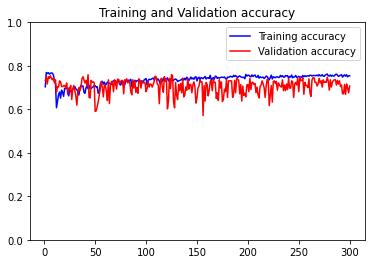

<Figure size 432x288 with 0 Axes>

In [52]:
# train processing plot
n_epochs = 300
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# 4. Attention Map

In [76]:
from vit_explain.vit_grad_rollout import VITAttentionGradRollout
from vit_explain.vit_rollout import VITAttentionRollout
from pytorch_grad_cam.utils.image import show_cam_on_image

y is 0 ; pre is 0 => True


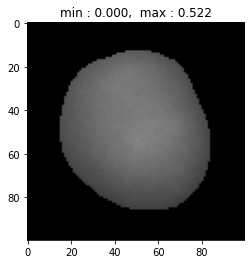

In [51]:
n = 199
img = train_data[n][0].permute(1,2,0).numpy()
label = train_data[n][1]
input_tensor = train_data[n][0].unsqueeze(0).to(device)
output = model(input_tensor)
y = output.argmax(1).cpu().item()
print("y is",y , "; pre is", label.item(), "=>",y==label.item())

plt.title("min : {:.3f},  max : {:.3f}".format(np.amin(img),np.amax(img)))
plt.imshow(img)

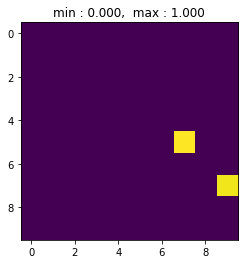

In [77]:
grad_rollout = VITAttentionGradRollout(model, attention_layer_name='transformer.layers.1.0.fn.attend', discard_ratio=0.9)
att_mask = grad_rollout(input_tensor,label)

# rollout = VITAttentionRollout(model, attention_layer_name='transformer.layers.1.0.fn.attend', discard_ratio=0.9)
# att_mask = rollout(input_tensor)

plt.title("min : {:.3f},  max : {:.3f}".format(np.amin(att_mask),np.amax(att_mask)))
plt.imshow(att_mask)

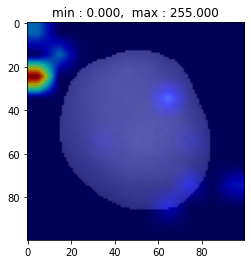

In [71]:
mask = cv2.resize(att_mask, (100, 100))
# img = np.float32(img)/255
mask = show_cam_on_image(img, mask, use_rgb=True)
plt.title("min : {:.3f},  max : {:.3f}".format(np.amin(mask),np.amax(mask)))
plt.imshow(mask)

In [94]:
def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='transformer.layers.1.0.fn.attend', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [98]:
rolloutaa = VITAttentionRollout(model)
att_mask = rolloutaa(input_tensor)

plt.title("min : {:.3f},  max : {:.3f}".format(np.amin(att_mask),np.amax(att_mask)))
plt.imshow(att_mask)

TypeError: __call__() takes 2 positional arguments but 4 were given

# 5. Feature map

In [55]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
    print(name)


to_patch_embedding
to_patch_embedding.0
to_patch_embedding.1
dropout
transformer
transformer.layers
transformer.layers.0
transformer.layers.0.0
transformer.layers.0.0.norm
transformer.layers.0.0.fn
transformer.layers.0.0.fn.attend
transformer.layers.0.0.fn.dropout
transformer.layers.0.0.fn.to_qkv
transformer.layers.0.0.fn.to_out
transformer.layers.0.0.fn.to_out.0
transformer.layers.0.0.fn.to_out.1
transformer.layers.0.1
transformer.layers.0.1.norm
transformer.layers.0.1.fn
transformer.layers.0.1.fn.net
transformer.layers.0.1.fn.net.0
transformer.layers.0.1.fn.net.1
transformer.layers.0.1.fn.net.2
transformer.layers.0.1.fn.net.3
transformer.layers.0.1.fn.net.4
transformer.layers.1
transformer.layers.1.0
transformer.layers.1.0.norm
transformer.layers.1.0.fn
transformer.layers.1.0.fn.attend
transformer.layers.1.0.fn.dropout
transformer.layers.1.0.fn.to_qkv
transformer.layers.1.0.fn.to_out
transformer.layers.1.0.fn.to_out.0
transformer.layers.1.0.fn.to_out.1
transformer.layers.1.1
transfo

In [22]:
key = "transformer.layers.1.0.fn.to_out"
# key = "transformer.layers.0.0.fn.attend"

bn = feature_activation[key].cpu()[0].numpy().mean(axis=0)
print(bn.shape)

plt.title(str(format(np.amax(bn)))+" "+str(format(np.amin(bn))))
plt.axis("off")
plt.imshow(bn)

In [19]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

## 3.0 Model structure 

In [22]:
model = ViT(
    image_size = 100,
    patch_size = 10,
    num_classes = 2,
    dim = 32,
    depth = 1,
    heads = 4,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [60]:
print(model.to_patch_embedding)

image_size = 100
test_input = torch.ones(1,3,image_size,image_size).to(device)
print(test_input.shape)
x1 = model.to_patch_embedding[0](test_input)
print(x1.shape)
x2 = model.to_patch_embedding[1](x1)
print(x2.shape)
x3 = model.dropout(x2)
print(x3.shape)

Sequential(
  (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=10, p2=10)
  (1): Linear(in_features=300, out_features=1024, bias=True)
)
torch.Size([1, 3, 100, 100])
torch.Size([1, 100, 300])
torch.Size([1, 100, 1024])
torch.Size([1, 100, 1024])


In [61]:
print(model.transformer.layers[0][0])

x4 = model.transformer.layers[0][0].norm(x3)
print("norm: ",x4.shape)
x5 = model.transformer.layers[0][0].fn.attend(x4)
print("attend: ",x5.shape)
x6 = model.transformer.layers[0][0].fn.dropout(x5)
print("dropout: ",x6.shape)

x7 = model.transformer.layers[0][0].fn.to_qkv(x6)
print("to_qkv: ",x7.shape)
dk = int(x7.shape[2]/3)
Q = x7[:,:,:dk]
K = x7[:,:,dk:dk*2]
V = x7[:,:,dk*2:]
x7 = torch.matmul(torch.matmul(Q, torch.transpose(K, 1,2))/np.sqrt(dk), V)
print("after_qkv: ",x7.shape)

x8 = model.transformer.layers[0][0].fn.to_out(x7)
print("to_out: ",x8.shape)

PreNorm(
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fn): Attention(
    (attend): Softmax(dim=-1)
    (dropout): Dropout(p=0.1, inplace=False)
    (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
    (to_out): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Dropout(p=0.1, inplace=False)
    )
  )
)
norm:  torch.Size([1, 100, 1024])
attend:  torch.Size([1, 100, 1024])
dropout:  torch.Size([1, 100, 1024])
to_qkv:  torch.Size([1, 100, 3072])
after_qkv:  torch.Size([1, 100, 1024])
to_out:  torch.Size([1, 100, 1024])


In [62]:
print(model.transformer.layers[0][1])

x9 = model.transformer.layers[0][1](x6)
print(x9.shape)

PreNorm(
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fn): FeedForward(
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=True)
      (1): GELU(approximate=none)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)
torch.Size([1, 100, 1024])


# 99. Save model

In [16]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model,"SelfViT.pkl")